In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
cd ~/GrowingNetwork/GroMo/misc

/home/tau/trudkiew/GrowingNetwork/GroMo/misc


/home/tau/trudkiew/miniconda3/envs/CONDA_3_12/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/tau/trudkiew/miniconda3/envs/CONDA_3_12/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
import torch
from gromo.tools import compute_optimal_added_parameters
from gromo.utils.datasets import get_dataset
from auxilliary_functions import *
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from typing import Iterable
import matplotlib.pyplot as plt

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device('cpu')
DEVICE

device(type='cuda')

In [9]:
def low_rank_linear_regression(batched_x_y_iterator: Iterable, 
                               d: int,
                               m: int,
                               one_hot: bool = False,
                               identity: bool = False,
                               numerical_threshold: float = 1e-6,
                               device: torch.device = torch.device('cpu')):
    """
    Compute the low rank linear regression of the data.
    
    Argmin_{W} ||XW - Y||
    X is a matrix of size (n, d)
    Y is a matrix of size (n, m)
    W is a matrix of size (d, m)
    
    Parameters
    ----------
    batched_x_y_iterator : Iterable
        Iterator over the batches of x and y. Each batch 
        is a tuple (X, Y) where X and Y are torch.Tensor of
        size (nb, d) and (nb, m) respectively. 
    d : int
        The size of the input space
    m : int
        The size of the output space
    one_hot : bool
        If True, the output space is a one hot encoding
    numerical_threshold : float
        The threshold for the numerical computation
        if the singular values of the matrix are smaller
        than the threshold, they are set to zero.
    device : torch.device
        The device to use for the computation
    
    Returns
    -------
    W : torch.Tensor
        The optimal matrix W of size (d, m).
    """
    if identity:
        m = d
    matrix_s = torch.zeros((d, d), device=device)
    matrix_m = torch.zeros((d, m), device=device)
    n = 0
    for x, y in tqdm(batched_x_y_iterator):
        x = x.to(device)
        y = y.to(device)
        if one_hot:
            y_one_hot = -torch.ones((y.shape[0], m), device=device)
            y_one_hot[torch.arange(y.shape[0]), y] = 1
            y = y_one_hot
        if identity:
            y = x
        matrix_s += x.t() @ x
        matrix_m += x.t() @ y
        n += x.shape[0]
    matrix_s /= n
    matrix_m /= n
    return compute_optimal_added_parameters(matrix_s, matrix_m,
                                            statistical_threshold=numerical_threshold,
                                            numerical_threshold=numerical_threshold)


 # Preliminary tests

In [5]:
def x_y_iterator(seed: int = 0, intrinsic_dim: int = 5, input_size=50):
    torch.manual_seed(0)
    w = torch.randn((input_size, intrinsic_dim))
    w = torch.cat((w, w, w), dim=1)
    torch.manual_seed(seed)
    for _ in range(input_size * intrinsic_dim):
        nb = torch.randint(5, 20, (1,))
        x = torch.randn((nb, input_size))
        y = x @ w
        yield x, y


In [6]:
def mse(batched_x_y_iterator, alpha, omega, device=DEVICE):
    sum_se = 0
    n = 0
    for x, y in batched_x_y_iterator:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        sum_se += torch.norm(x @ alpha.t() @ omega.t() - y) ** 2
        n += x.shape[0]
    return sum_se / n

In [7]:
intra_dim = 6
W = low_rank_linear_regression(x_y_iterator(intrinsic_dim=intra_dim), 50, 3 * intra_dim, device=DEVICE)

0it [00:00, ?it/s]

[W Context.cpp:258] Warning: torch.backends.cuda.preferred_linalg_library is an experimental feature. If you see any error or unexpected behavior when this flag is set please file an issue on GitHub. (function operator())


In [8]:
W

(tensor([[-7.6041e-01, -7.3464e-01,  8.8520e-01, -5.5085e-01, -6.8621e-01,
           5.3699e-02, -1.0925e-01,  1.0269e+00,  1.7501e-01, -1.1716e+00,
          -7.6082e-01,  7.9238e-01, -5.1500e-01,  3.6354e-01, -5.9719e-01,
          -5.8947e-01,  1.0784e+00, -1.9047e-01,  5.3962e-01,  1.7314e-01,
          -6.9359e-01,  3.0894e-01, -1.1015e-01, -4.4353e-01, -3.2815e-02,
           1.3913e-01,  1.2070e-01, -4.2260e-01,  5.2333e-01,  1.6102e-01,
           6.2980e-01,  6.6107e-01, -2.5844e-01, -2.8884e-01, -4.4700e-01,
           9.5762e-01,  4.1174e-01, -7.7588e-02,  8.9013e-02,  5.5057e-01,
          -8.7922e-01,  1.8943e-01,  1.1113e-01, -2.3919e-01,  5.7854e-01,
           4.9523e-01, -6.6540e-01,  1.1834e-01, -8.3991e-03,  9.2958e-01],
         [-1.4645e-01, -7.4158e-01, -5.7034e-01,  1.0191e-01,  5.8569e-01,
           2.2231e-02,  1.9839e-01, -1.6449e-01, -1.7132e-01,  1.2025e+00,
          -8.2838e-01,  1.2978e+00, -2.4392e-01,  2.1100e-01,  3.2919e-01,
          -6.5341e-02, -

In [9]:
W[0].shape, W[1].shape, W[2].shape

(torch.Size([7, 50]), torch.Size([18, 7]), torch.Size([7]))

In [10]:
mse(x_y_iterator(intrinsic_dim=intra_dim, seed=1), W[0], W[1])

tensor(1.8814e-09, device='cuda:0')

In [11]:
cut = intra_dim
mse(x_y_iterator(intrinsic_dim=intra_dim, seed=1), W[0][:cut], W[1][:, :cut]), (W[2][cut:] ** 2).sum()

(tensor(1.8802e-09, device='cuda:0'), tensor(1.1809e-12, device='cuda:0'))

In [12]:
cut = intra_dim - 1
mse(x_y_iterator(intrinsic_dim=intra_dim, seed=1), W[0][:cut], W[1][:, :cut]), (W[2][cut:] ** 2).sum()

(tensor(78.2508, device='cuda:0'), tensor(76.7492, device='cuda:0'))

In [13]:
cut = intra_dim - 2
mse(x_y_iterator(intrinsic_dim=intra_dim, seed=1), W[0][:cut], W[1][:, :cut]), (W[2][cut:] ** 2).sum()

(tensor(164.1105, device='cuda:0'), tensor(158.8602, device='cuda:0'))

In [14]:
W[2]

tensor([1.5354e+01, 1.3260e+01, 1.0476e+01, 9.7872e+00, 9.0615e+00, 8.7607e+00,
        1.0867e-06], device='cuda:0')

# Datasets

In [10]:
def init_model(alpha: torch.Tensor = None,
               omega: torch.Tensor = None, 
               cut: int = 10,
               input_size: int = 784,
               nb_classes: int = 10,
               device: torch.device=DEVICE,
               activation: torch.nn.Module=torch.nn.Identity()):
    l1 = torch.nn.Linear(input_size, cut)
    if alpha is not None:
        l1.weight.data = torch.clone(alpha[:cut])
        l1.bias.data = torch.zeros_like(l1.bias.data)

    l2 = torch.nn.Linear(cut, nb_classes)
    if omega is not None:
        l2.weight.data = torch.clone(omega[:nb_classes, :cut])
        l2.bias.data = torch.zeros_like(l2.bias.data)

    return torch.nn.Sequential(l1, 
                              activation, 
                              l2).to(device)

In [11]:
def train_and_plot(model: torch.nn.Module,
                    train_dataloader: DataLoader,
                    val_dataloader: DataLoader,
                    loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(reduction='mean'),
                    nb_epoch: int = 20,
                    show: bool = True,
                    cut: int = 10,
                    device: torch.device = DEVICE):
    results = train(model=model,
                    train_dataloader=train_dataloader,
                    val_dataloader=val_dataloader,
                    loss_function=loss_function,
                    nb_epoch=nb_epoch,
                    show=show,
                    device=device)
    loss_train, accuracy_train, loss_val, accuracy_val = results

    plt.title(f"Loss for {cut} neurons (final val loss: {loss_val[-1]:.2e}, final train loss: {loss_train[-1]:.2e})")
    plt.plot(loss_train, label="train")
    plt.plot(loss_val, label="val")
    plt.legend()
    plt.show()

    plt.title(f"Accuracy for {cut} neurons (final accuracy: {100 * accuracy_val[-1]:.1f}%, final train accuracy: {100 * accuracy_train[-1]:.1f}%)")
    plt.plot(accuracy_train, label="train")
    plt.plot(accuracy_val, label="val")
    plt.legend()
    plt.show()

In [12]:
def eval_model(model: torch.nn.Module,
               data_loader: DataLoader):
    loss, acc = evaluate_model(model, 
                dataloader=data_loader, 
                loss_function=torch.nn.CrossEntropyLoss(),
                device=DEVICE)
    print(f"Loss: {loss:.2e}, Accuracy: {100 * acc:.1f}%")
    return loss, acc

## MNIST

In [14]:
DATASET = "mnist"
K = 10
train_data, val_data, _ = get_dataset(DATASET,
                                      dataset_path="dataset",
                                      nb_class=K,
                                      split_train_val=0.3)
train_data, val_data

(<torch.utils.data.dataset.Subset at 0x79da9b53e690>,
 <torch.utils.data.dataset.Subset at 0x79da3799a410>)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
input_size = next(iter(train_dataloader))[0].shape[1:].numel()
f"Training data: {len(train_dataloader):.2e}, Validation data: {len(val_dataloader):.2e}, Input size: {input_size}"

'Training data: 6.57e+02, Validation data: 2.82e+02, Input size: 784'

In [18]:
def train_and_plot_mnist(model: torch.nn.Module,
                        train_dataloader: DataLoader = train_dataloader,
                        val_dataloader: DataLoader = val_dataloader,
                        loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(reduction='mean'),
                        nb_epoch: int = 20,
                        show: bool = True,
                        cut: int = 10,
                        device: torch.device = DEVICE):
    return train_and_plot(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_function=loss_function,
        nb_epoch=nb_epoch,
        show=show,
        cut=cut,
        device=device
    )

def eval_model_mnist(model: torch.nn.Module,
                    data_loader: DataLoader = val_dataloader):
    return eval_model(
        model=model,
        data_loader=data_loader
    )

In [11]:
W = low_rank_linear_regression(train_dataloader, input_size, K, one_hot=True, device=DEVICE)

  0%|          | 0/657 [00:00<?, ?it/s]

[W Context.cpp:258] Warning: torch.backends.cuda.preferred_linalg_library is an experimental feature. If you see any error or unexpected behavior when this flag is set please file an issue on GitHub. (function operator())


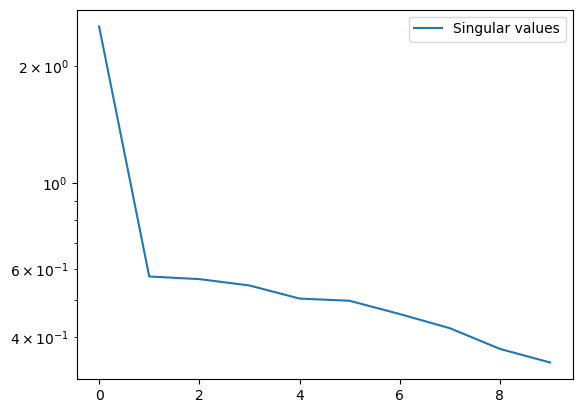

In [12]:
plt.plot(W[2].cpu().numpy(), label='Singular values')
plt.yscale('log')
plt.legend()

In [16]:
c = 10

In [19]:
net = init_model(W[0], W[1], c)
eval_model_mnist(net)
net

Loss: 1.41e+00, Accuracy: 84.9%


Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): Identity()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

In [20]:
net = init_model(W[0], W[1], c, activation=torch.nn.SELU())
eval_model_mnist(net)
net

Loss: 1.36e+00, Accuracy: 84.7%


Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=5.097e-01, accuracy=0.88	 Val: loss=3.740e-01, accuracy=0.90
Epoch 1:	 Train: loss=3.259e-01, accuracy=0.91	 Val: loss=3.262e-01, accuracy=0.91
Epoch 2:	 Train: loss=2.983e-01, accuracy=0.91	 Val: loss=3.115e-01, accuracy=0.91


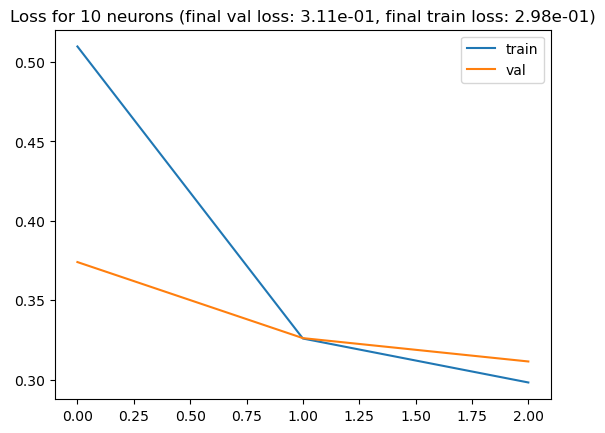

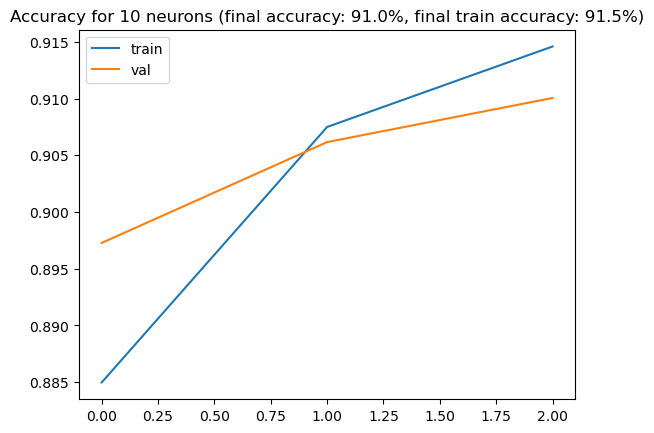

In [21]:
train_and_plot_mnist(net, nb_epoch=3, cut=c)

In [22]:
net = init_model(cut=c, activation=torch.nn.SELU())
eval_model_mnist(net)
net

Loss: 2.40e+00, Accuracy: 8.7%


Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=6.694e-01, accuracy=0.82	 Val: loss=4.213e-01, accuracy=0.88
Epoch 1:	 Train: loss=3.730e-01, accuracy=0.89	 Val: loss=3.567e-01, accuracy=0.89
Epoch 2:	 Train: loss=3.319e-01, accuracy=0.90	 Val: loss=3.301e-01, accuracy=0.90


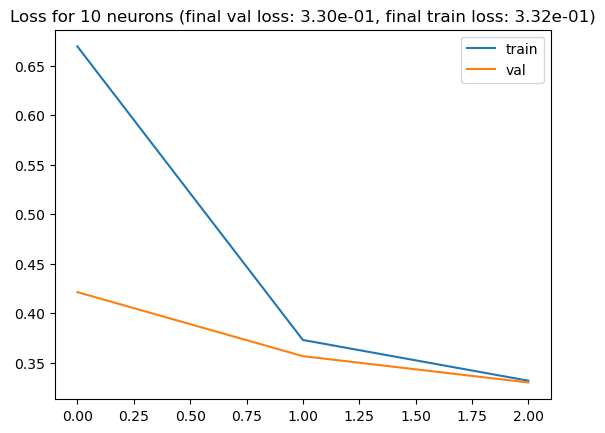

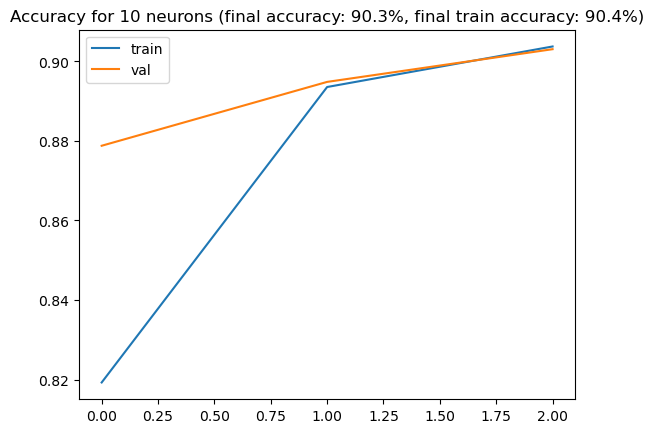

In [23]:
train_and_plot_mnist(net, nb_epoch=3, cut=c)

### C = 5

In [24]:
c = 5

In [25]:
net = init_model(W[0], W[1], c)
eval_model_mnist(net)
net

Loss: 1.78e+00, Accuracy: 58.7%


Sequential(
  (0): Linear(in_features=784, out_features=5, bias=True)
  (1): Identity()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

In [26]:
net = init_model(W[0], W[1], c, activation=torch.nn.SELU())
eval_model_mnist(net)
net

Loss: 1.75e+00, Accuracy: 58.4%


Sequential(
  (0): Linear(in_features=784, out_features=5, bias=True)
  (1): SELU()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=8.175e-01, accuracy=0.77	 Val: loss=5.652e-01, accuracy=0.83
Epoch 1:	 Train: loss=4.978e-01, accuracy=0.86	 Val: loss=4.767e-01, accuracy=0.86
Epoch 2:	 Train: loss=4.500e-01, accuracy=0.87	 Val: loss=4.484e-01, accuracy=0.87


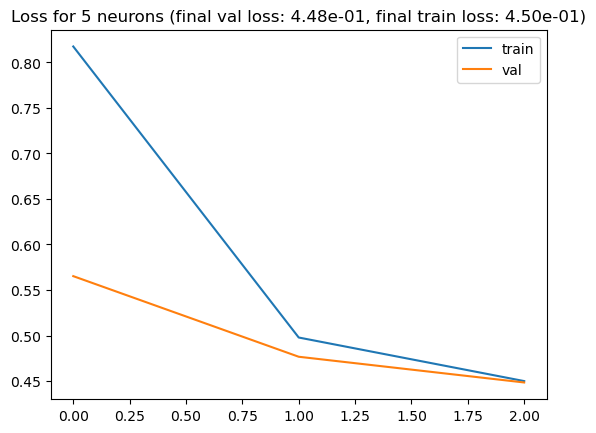

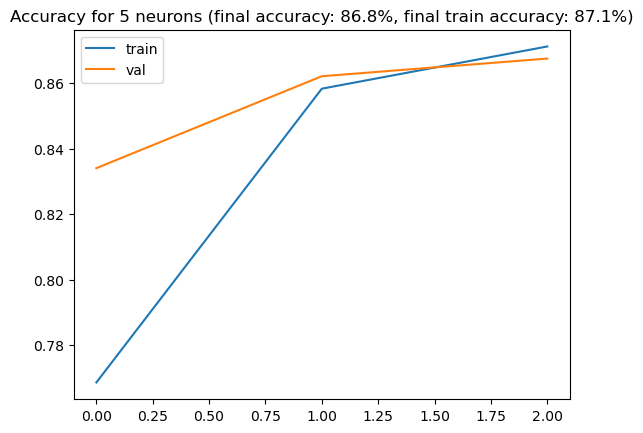

In [27]:
train_and_plot_mnist(net, nb_epoch=3, cut=c)

In [28]:
net = init_model(cut=c, activation=torch.nn.SELU())
eval_model_mnist(net)
net

Loss: 2.43e+00, Accuracy: 9.1%


Sequential(
  (0): Linear(in_features=784, out_features=5, bias=True)
  (1): SELU()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.049e+00, accuracy=0.69	 Val: loss=7.373e-01, accuracy=0.80
Epoch 1:	 Train: loss=6.312e-01, accuracy=0.83	 Val: loss=5.912e-01, accuracy=0.83
Epoch 2:	 Train: loss=5.411e-01, accuracy=0.85	 Val: loss=5.373e-01, accuracy=0.85


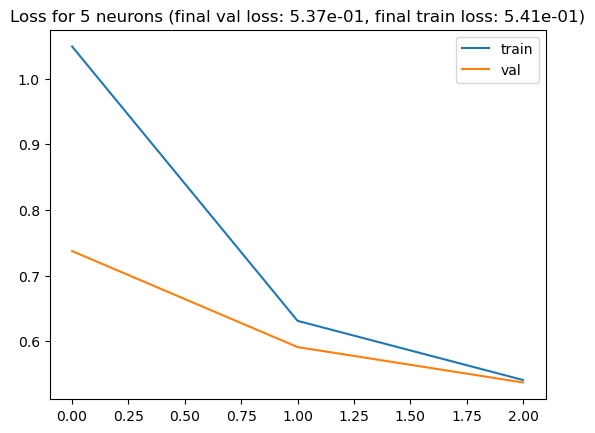

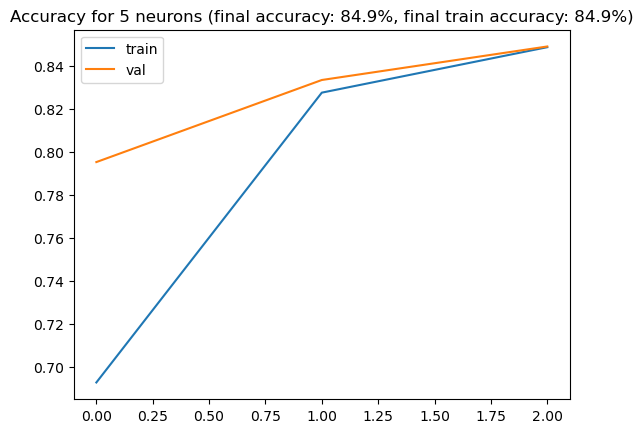

In [29]:
train_and_plot_mnist(net, nb_epoch=3, cut=c)

## Cifar10

In [13]:
DATASET = "cifar10"
K = 10
train_data, val_data, _ = get_dataset(DATASET,
                                      dataset_path="dataset",
                                      nb_class=K,
                                      split_train_val=0.3)
train_data, val_data

100%|██████████| 170498071/170498071 [00:08<00:00, 20711694.14it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


(<torch.utils.data.dataset.Subset at 0x7f0493f81280>,
 <torch.utils.data.dataset.Subset at 0x7f0493f815e0>)

In [14]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
input_size = next(iter(train_dataloader))[0].shape[1:].numel()
f"Training data: {len(train_dataloader):.2e}, Validation data: {len(val_dataloader):.2e}, Input size: {input_size}"

'Training data: 5.47e+02, Validation data: 2.35e+02, Input size: 3072'

In [15]:
def train_and_plot_cifar10(model: torch.nn.Module,
                        train_dataloader: DataLoader = train_dataloader,
                        val_dataloader: DataLoader = val_dataloader,
                        loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(reduction='mean'),
                        nb_epoch: int = 20,
                        show: bool = True,
                        cut: int = 10,
                        device: torch.device = DEVICE):
    return train_and_plot(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_function=loss_function,
        nb_epoch=nb_epoch,
        show=show,
        cut=cut,
        device=device
    )

def eval_model_cifar10(model: torch.nn.Module,
                    data_loader: DataLoader = val_dataloader):
    return eval_model(
        model=model,
        data_loader=data_loader
    )

In [16]:
W = low_rank_linear_regression(train_dataloader, input_size, K, one_hot=True, device=DEVICE)

  0%|          | 0/547 [00:00<?, ?it/s]

[W824 18:16:41.904688705 Context.cpp:258] Warning: torch.backends.cuda.preferred_linalg_library is an experimental feature. If you see any error or unexpected behavior when this flag is set please file an issue on GitHub. (function operator())


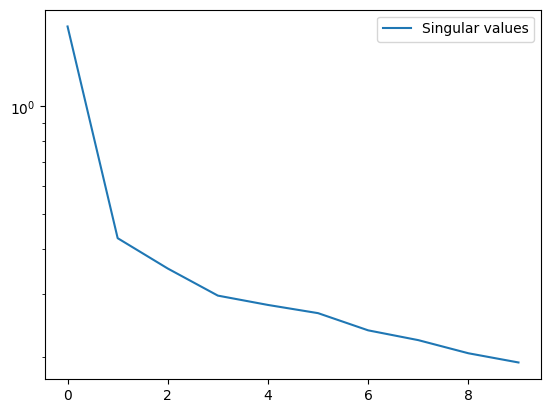

In [17]:
plt.plot(W[2].cpu().numpy(), label='Singular values')
plt.yscale('log')
plt.legend()

In [18]:
c = 10

In [19]:
net = init_model(W[0], W[1], c, input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.11e+00, Accuracy: 33.9%


Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): Identity()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

In [20]:
net = init_model(W[0], W[1], c, activation=torch.nn.SELU(), input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.09e+00, Accuracy: 33.6%


Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.693e+00, accuracy=0.45	 Val: loss=1.806e+00, accuracy=0.37
Epoch 3:	 Train: loss=1.560e+00, accuracy=0.47	 Val: loss=1.795e+00, accuracy=0.38
Epoch 6:	 Train: loss=1.541e+00, accuracy=0.47	 Val: loss=1.817e+00, accuracy=0.37
Epoch 9:	 Train: loss=1.526e+00, accuracy=0.48	 Val: loss=1.773e+00, accuracy=0.39
Epoch 12:	 Train: loss=1.516e+00, accuracy=0.48	 Val: loss=1.802e+00, accuracy=0.38
Epoch 15:	 Train: loss=1.505e+00, accuracy=0.49	 Val: loss=1.797e+00, accuracy=0.38
Epoch 18:	 Train: loss=1.492e+00, accuracy=0.49	 Val: loss=1.784e+00, accuracy=0.39
Epoch 21:	 Train: loss=1.487e+00, accuracy=0.49	 Val: loss=1.810e+00, accuracy=0.38
Epoch 24:	 Train: loss=1.480e+00, accuracy=0.49	 Val: loss=1.819e+00, accuracy=0.39
Epoch 27:	 Train: loss=1.472e+00, accuracy=0.49	 Val: loss=1.791e+00, accuracy=0.38


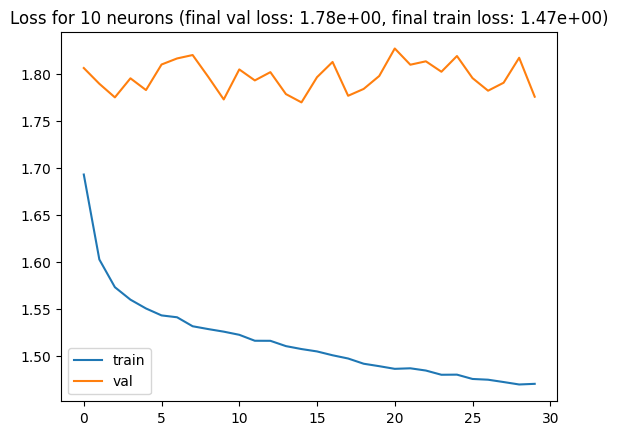

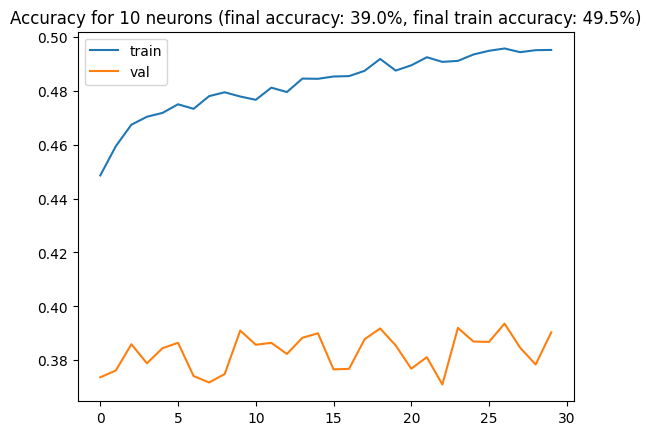

In [21]:
train_and_plot_cifar10(net, nb_epoch=30, cut=c)

In [22]:
net = init_model(cut=c, activation=torch.nn.SELU(), input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.35e+00, Accuracy: 8.9%


Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.924e+00, accuracy=0.32	 Val: loss=1.812e+00, accuracy=0.37
Epoch 3:	 Train: loss=1.678e+00, accuracy=0.41	 Val: loss=1.706e+00, accuracy=0.41
Epoch 6:	 Train: loss=1.629e+00, accuracy=0.43	 Val: loss=1.682e+00, accuracy=0.42
Epoch 9:	 Train: loss=1.598e+00, accuracy=0.44	 Val: loss=1.676e+00, accuracy=0.41
Epoch 12:	 Train: loss=1.570e+00, accuracy=0.45	 Val: loss=1.643e+00, accuracy=0.43
Epoch 15:	 Train: loss=1.551e+00, accuracy=0.45	 Val: loss=1.633e+00, accuracy=0.43
Epoch 18:	 Train: loss=1.539e+00, accuracy=0.46	 Val: loss=1.635e+00, accuracy=0.42
Epoch 21:	 Train: loss=1.528e+00, accuracy=0.46	 Val: loss=1.638e+00, accuracy=0.43
Epoch 24:	 Train: loss=1.517e+00, accuracy=0.47	 Val: loss=1.642e+00, accuracy=0.42
Epoch 27:	 Train: loss=1.512e+00, accuracy=0.47	 Val: loss=1.638e+00, accuracy=0.43


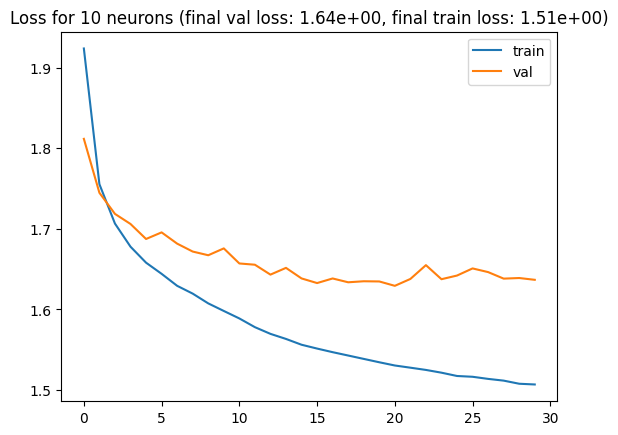

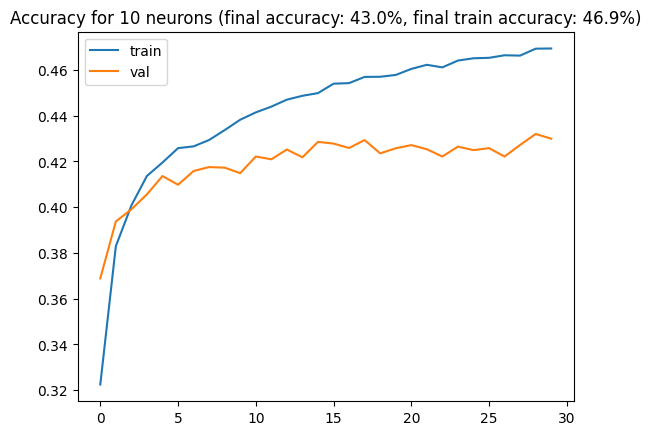

In [23]:
train_and_plot_cifar10(net, nb_epoch=30, cut=c)

In [24]:
net = init_model(cut=c, activation=torch.nn.SELU(), input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.37e+00, Accuracy: 10.4%


Sequential(
  (0): Linear(in_features=3072, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.906e+00, accuracy=0.33	 Val: loss=1.806e+00, accuracy=0.37
Epoch 3:	 Train: loss=1.673e+00, accuracy=0.42	 Val: loss=1.712e+00, accuracy=0.40
Epoch 6:	 Train: loss=1.627e+00, accuracy=0.43	 Val: loss=1.691e+00, accuracy=0.41
Epoch 9:	 Train: loss=1.602e+00, accuracy=0.44	 Val: loss=1.693e+00, accuracy=0.41
Epoch 12:	 Train: loss=1.583e+00, accuracy=0.45	 Val: loss=1.667e+00, accuracy=0.42
Epoch 15:	 Train: loss=1.568e+00, accuracy=0.45	 Val: loss=1.677e+00, accuracy=0.42
Epoch 18:	 Train: loss=1.558e+00, accuracy=0.45	 Val: loss=1.675e+00, accuracy=0.42
Epoch 21:	 Train: loss=1.548e+00, accuracy=0.46	 Val: loss=1.679e+00, accuracy=0.42
Epoch 24:	 Train: loss=1.539e+00, accuracy=0.46	 Val: loss=1.671e+00, accuracy=0.42
Epoch 27:	 Train: loss=1.531e+00, accuracy=0.46	 Val: loss=1.675e+00, accuracy=0.42


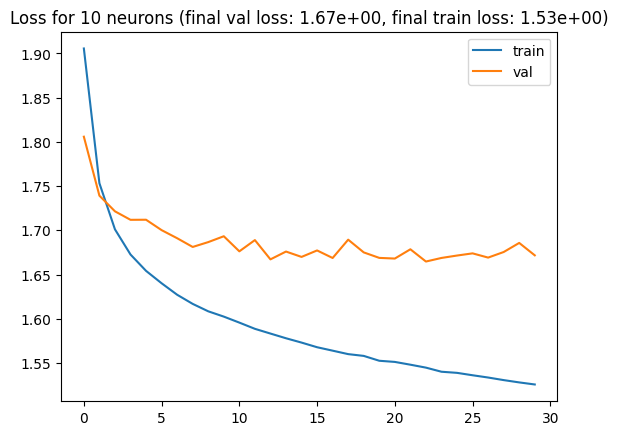

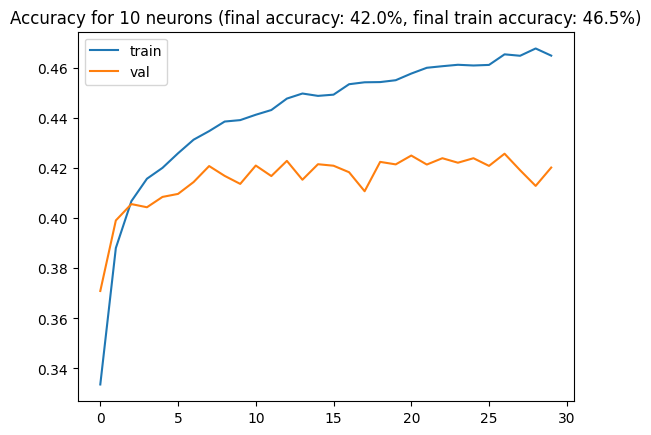

In [25]:
train_and_plot_cifar10(net, nb_epoch=30, cut=c)

### C = 5

In [26]:
c = 5

In [27]:
net = init_model(W[0], W[1], c, input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.14e+00, Accuracy: 29.3%


Sequential(
  (0): Linear(in_features=3072, out_features=5, bias=True)
  (1): Identity()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

In [28]:
net = init_model(W[0], W[1], c, activation=torch.nn.SELU(), input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.13e+00, Accuracy: 28.9%


Sequential(
  (0): Linear(in_features=3072, out_features=5, bias=True)
  (1): SELU()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.836e+00, accuracy=0.36	 Val: loss=1.844e+00, accuracy=0.34
Epoch 3:	 Train: loss=1.713e+00, accuracy=0.39	 Val: loss=1.798e+00, accuracy=0.36
Epoch 6:	 Train: loss=1.691e+00, accuracy=0.39	 Val: loss=1.795e+00, accuracy=0.36
Epoch 9:	 Train: loss=1.682e+00, accuracy=0.40	 Val: loss=1.792e+00, accuracy=0.36
Epoch 12:	 Train: loss=1.671e+00, accuracy=0.40	 Val: loss=1.823e+00, accuracy=0.35
Epoch 15:	 Train: loss=1.668e+00, accuracy=0.40	 Val: loss=1.826e+00, accuracy=0.35
Epoch 18:	 Train: loss=1.661e+00, accuracy=0.40	 Val: loss=1.797e+00, accuracy=0.36
Epoch 21:	 Train: loss=1.658e+00, accuracy=0.40	 Val: loss=1.811e+00, accuracy=0.36
Epoch 24:	 Train: loss=1.651e+00, accuracy=0.40	 Val: loss=1.819e+00, accuracy=0.35
Epoch 27:	 Train: loss=1.650e+00, accuracy=0.41	 Val: loss=1.804e+00, accuracy=0.36


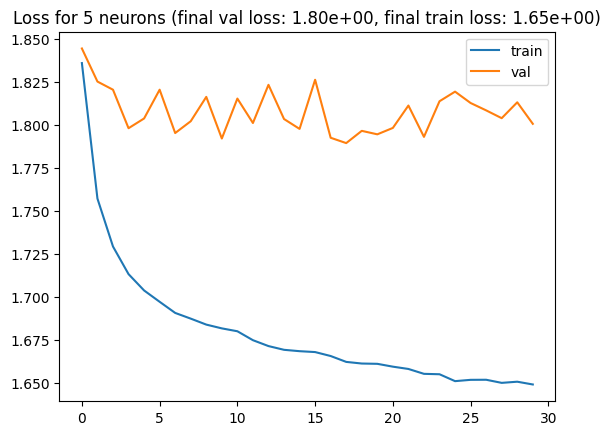

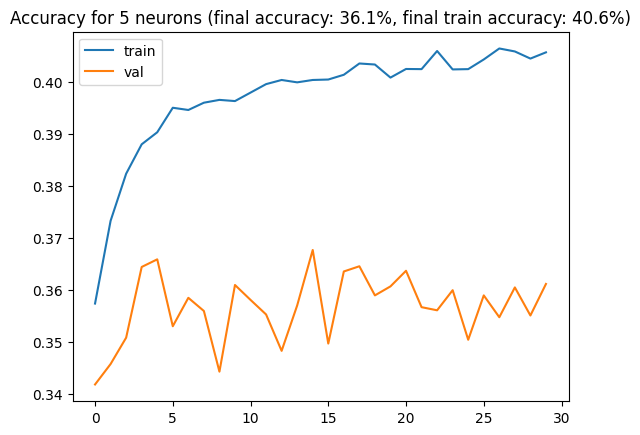

In [29]:
train_and_plot_cifar10(net, nb_epoch=30, cut=c)

In [30]:
net = init_model(cut=c, activation=torch.nn.SELU(), input_size=input_size, nb_classes=K)
eval_model_cifar10(net)
net

Loss: 2.37e+00, Accuracy: 9.5%


Sequential(
  (0): Linear(in_features=3072, out_features=5, bias=True)
  (1): SELU()
  (2): Linear(in_features=5, out_features=10, bias=True)
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0:	 Train: loss=1.969e+00, accuracy=0.30	 Val: loss=1.904e+00, accuracy=0.32
Epoch 3:	 Train: loss=1.785e+00, accuracy=0.37	 Val: loss=1.813e+00, accuracy=0.36
Epoch 6:	 Train: loss=1.750e+00, accuracy=0.38	 Val: loss=1.822e+00, accuracy=0.35
Epoch 9:	 Train: loss=1.730e+00, accuracy=0.39	 Val: loss=1.783e+00, accuracy=0.37
Epoch 12:	 Train: loss=1.716e+00, accuracy=0.39	 Val: loss=1.774e+00, accuracy=0.38
Epoch 15:	 Train: loss=1.706e+00, accuracy=0.39	 Val: loss=1.771e+00, accuracy=0.37
Epoch 18:	 Train: loss=1.700e+00, accuracy=0.39	 Val: loss=1.762e+00, accuracy=0.37
Epoch 21:	 Train: loss=1.693e+00, accuracy=0.39	 Val: loss=1.773e+00, accuracy=0.37
Epoch 24:	 Train: loss=1.689e+00, accuracy=0.40	 Val: loss=1.770e+00, accuracy=0.38
Epoch 27:	 Train: loss=1.684e+00, accuracy=0.40	 Val: loss=1.779e+00, accuracy=0.37


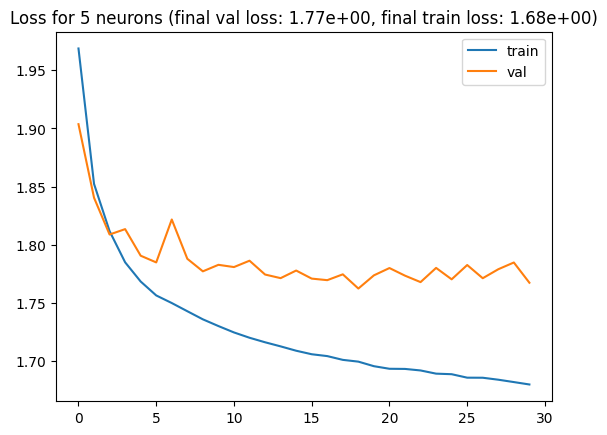

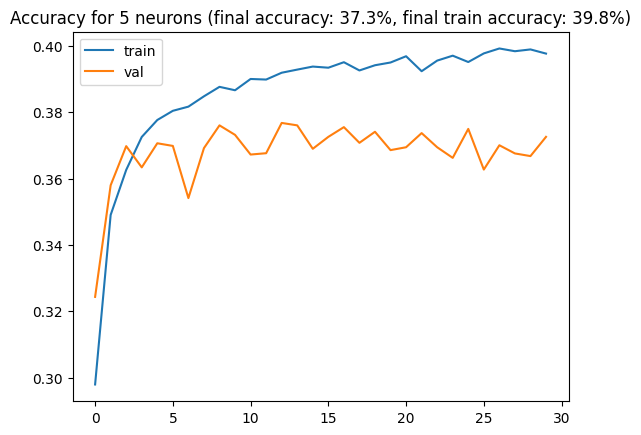

In [31]:
train_and_plot_cifar10(net, nb_epoch=30, cut=c)